In [1]:
%env OMP_NUM_THREADS=1
import firedrake as fd
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import hankel1
from scattering import *

env: OMP_NUM_THREADS=1


In [2]:
c = 340
a0 = b0 = 2.0
a1 = b1 = 2.25
x0 = np.array([0.5, 0])
h0 = 2 * a0 / 16

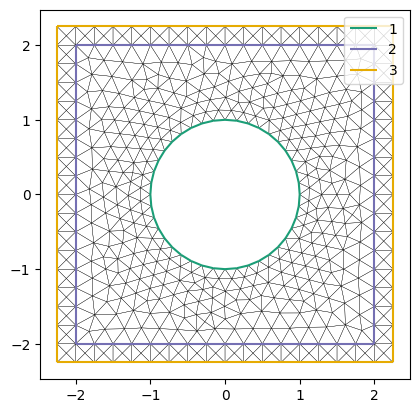

In [3]:
mesh = fd.Mesh("sphere.msh")
plot_mesh(mesh)

In [4]:
def exact_solution(k, x0):
    def f(x):
        dist = np.linalg.norm(x - x0, axis=1)
        return 1j / 4 * hankel1(0, k * dist)
    return f
    
def neumann_bc(k, x0):
    def f(x):
        dist = np.linalg.norm(x - x0, axis=1)
        return -1j / 4 * hankel1(1, k * dist) * k / dist \
               * np.einsum("ij,ij->i", x - x0, -x)
    return f

In [5]:
omega = 250
k = omega / c
g_data = exact_solution(k, x0)
uh = solve(mesh, k, a1, b1, g_data)

Exact solution:


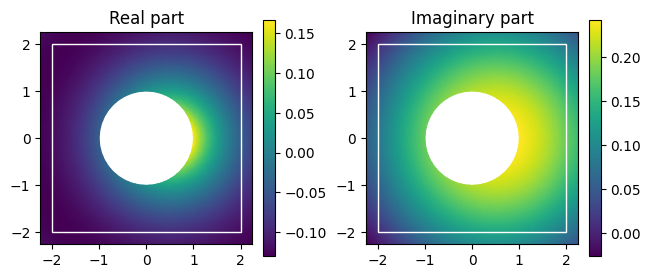

In [6]:
W = fd.VectorFunctionSpace(mesh, "CG", 1)
u = interpolate(W, exact_solution(k, x0))
print("Exact solution:")
plot_field(u, a0, a1, b0, b1)

Numerical solution:


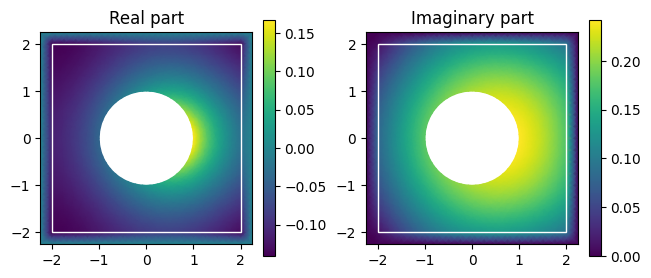

In [7]:
print("Numerical solution:")
plot_field(uh, a0, a1, b0, b1)

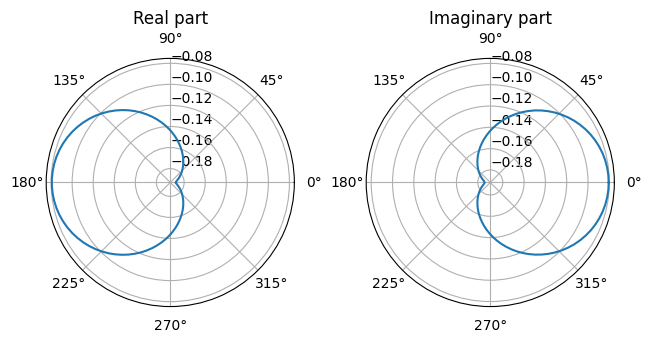

In [8]:
plot_far_field(k, uh)

In [9]:
# Convergence
max_level = 5
levels = np.arange(max_level)
mesh_hierarchy = fd.MeshHierarchy(mesh, max_level)
hs = h0 / 2**levels

angular freqency = 250
refinement level 0, relative error 3.12%
refinement level 1, relative error 2.25%
refinement level 2, relative error 1.36%
refinement level 3, relative error 0.32%
refinement level 4, relative error 0.16%
----------------------------------------
angular freqency = 750
refinement level 0, relative error 3.69%
refinement level 1, relative error 3.17%
refinement level 2, relative error 1.16%
refinement level 3, relative error 0.28%
refinement level 4, relative error 0.08%
----------------------------------------
angular freqency = 1250
refinement level 0, relative error 11.91%
refinement level 1, relative error 4.98%
refinement level 2, relative error 1.34%
refinement level 3, relative error 0.26%
refinement level 4, relative error 0.06%
----------------------------------------


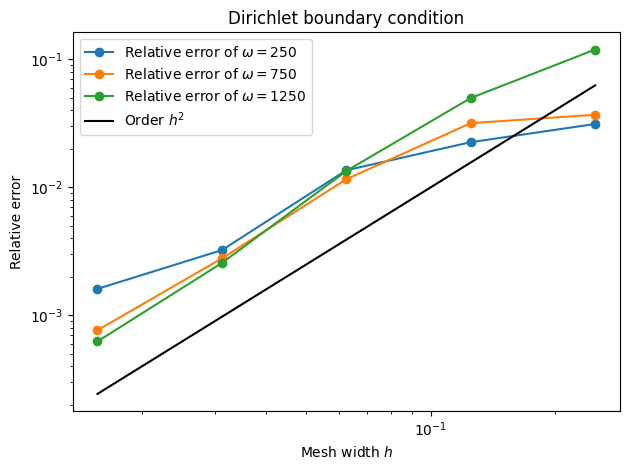

In [10]:
# Dirichlet problem
neumann = False
for omega in [250, 750, 1250]:
    print(f"angular freqency = {omega}")
    k = omega / c
    g_fct = exact_solution(k, x0)
    errors = []
    for level in levels:
        m = mesh_hierarchy[level]
        W = fd.VectorFunctionSpace(m, "CG", 1)
        u = interpolate(W, exact_solution(k, x0))
        uh = solve(m, k, a1, b1, g_fct, neumann)
        rel_err = compute_error(u, uh)
        print(f"refinement level {level}, relative error {rel_err:.2%}")
        errors.append(rel_err)
    plt.loglog(hs, errors, "-o",
               label=r"Relative error of $\omega=$"+f"{omega}")
    print("----------------------------------------")

plt.loglog(hs, hs**2, "k", label=r"Order $h^2$")
plt.legend()
plt.xlabel(r"Mesh width $h$")
plt.ylabel("Relative error")
plt.title("Dirichlet boundary condition")
plt.tight_layout()

angular freqency = 250
refinement level 0, relative error 5.93%
refinement level 1, relative error 3.52%
refinement level 2, relative error 1.99%
refinement level 3, relative error 0.55%
refinement level 4, relative error 0.30%
----------------------------------------
angular freqency = 750
refinement level 0, relative error 4.41%
refinement level 1, relative error 3.17%
refinement level 2, relative error 1.06%
refinement level 3, relative error 0.26%
refinement level 4, relative error 0.12%
----------------------------------------
angular freqency = 1250
refinement level 0, relative error 11.38%
refinement level 1, relative error 5.99%
refinement level 2, relative error 1.69%
refinement level 3, relative error 0.33%
refinement level 4, relative error 0.12%
----------------------------------------


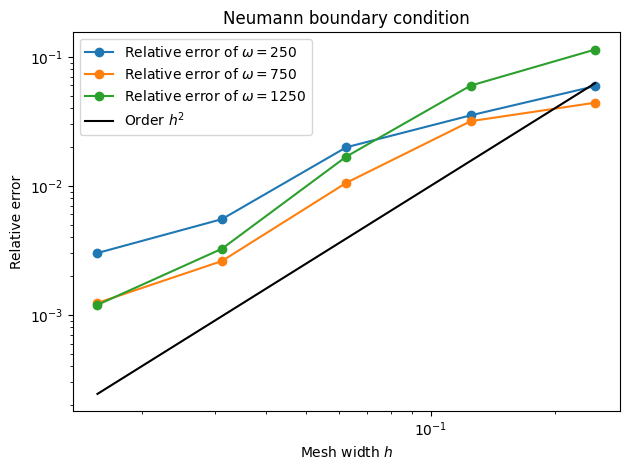

In [11]:
# Neumann problem
neumann = True
for omega in [250, 750, 1250]:
    print(f"angular freqency = {omega}")
    k = omega / c
    g_fct = neumann_bc(k, x0)
    errors = []
    for level in levels:
        m = mesh_hierarchy[level]
        W = fd.VectorFunctionSpace(m, "CG", 1)
        u = interpolate(W, exact_solution(k, x0))
        uh = solve(m, k, a1, b1, g_fct, neumann)
        rel_err = compute_error(u, uh)
        print(f"refinement level {level}, relative error {rel_err:.2%}")
        errors.append(rel_err)
    plt.loglog(hs, errors, "-o",
               label=r"Relative error of $\omega=$"+f"{omega}")
    print("----------------------------------------")

plt.loglog(hs, hs**2, "k", label=r"Order $h^2$")
plt.legend()
plt.xlabel(r"Mesh width $h$")
plt.ylabel("Relative error")
plt.title("Neumann boundary condition")
plt.tight_layout()